In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.common.utils.image import load_image
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.object_detection.models.yolov1 import YOLOV1Modified, YOLOLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [2]:
# import time
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov1')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 2

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov1",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
)

# data

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 448

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(p=0.5),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
# train_dataset = VOCDetectionFromCSV(
#     data_path,
#     data_path.joinpath("voc_trainval.csv"),
#     transform=transform,
# )

In [11]:
train_dataset = VOCDetectionFromLMDB(
    "../../data/VOCdevkit/voc",
    transform=transform,
)

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 448, 448]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([32, 3, 448, 448]) 32


# model

In [15]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["4_1"])

In [16]:
model = YOLOV1Modified(backbone, CONTEXT, dropout_prob=0).to(CONTEXT.device)

In [17]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV1Modified                                     --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Sequential: 3-1                        9,536
│    │    └─Sequential: 3-2                        221,952
│    │    └─Sequential: 3-3                        1,116,416
│    │    └─Sequential: 3-4                        6,822,400
│    │    └─Sequential: 3-5                        13,114,368
│    │    └─AdaptiveAvgPool2d: 3-6                 --
│    └─ImageNetNormalization: 2-2                  --
├─Sequential: 1-2                                  --
│    └─Conv2dNormActivation: 2-3                   --
│    │    └─Conv2d: 3-7                            4,718,592
│    │    └─BatchNorm2d: 3-8                       2,048
│    │    └─LeakyReLU: 3-9                         --
│    └─Conv2dNormActivation: 2-4                   --
│    │    └─Conv2d: 3-10             

# train

In [18]:
EPOCH = 10

In [19]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(CONTEXT, lambda_coord=5, lambda_noobject=0.5)

In [21]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [22]:
# TODO: longer epoch
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
)

100%|██████████| 517/517 [03:50<00:00,  2.25it/s]


epoch 1 : 2.028847611157991 (0%)


100%|██████████| 517/517 [03:46<00:00,  2.28it/s]


epoch 2 : 1.343628858574585 (-34%)


100%|██████████| 517/517 [03:50<00:00,  2.25it/s]


epoch 3 : 1.1711657902719435 (-13%)


100%|██████████| 517/517 [03:44<00:00,  2.31it/s]


epoch 4 : 1.0718172274429056 (-8%)


100%|██████████| 517/517 [03:31<00:00,  2.45it/s]


epoch 5 : 1.0013622830638111 (-7%)


100%|██████████| 517/517 [03:31<00:00,  2.45it/s]


epoch 6 : 0.9353061619302983 (-7%)


100%|██████████| 517/517 [03:30<00:00,  2.45it/s]


epoch 7 : 0.8871982027299169 (-5%)


100%|██████████| 517/517 [03:30<00:00,  2.45it/s]


epoch 8 : 0.8784449250370667 (-1%)


100%|██████████| 517/517 [03:30<00:00,  2.45it/s]


epoch 9 : 0.8155074159919178 (-7%)


100%|██████████| 517/517 [03:30<00:00,  2.46it/s]

epoch 10 : 0.7783123109511296 (-5%)


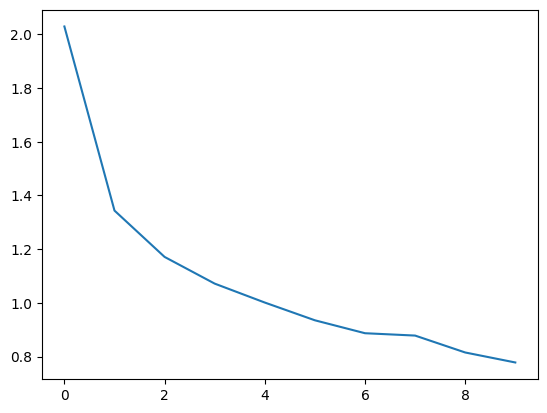

In [35]:
plt.plot(training_loss)

In [32]:
model_path = artifact_path / f'yolov1.{backbone.network_name}.dropout.{model.dropout_prob}.colorjitter.pth'

In [33]:
torch.save(model.state_dict(), model_path)

In [34]:
get_file_size(model_path)

'216.44MiB'

In [ ]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Inference

In [36]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [37]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [38]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [39]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [40]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [41]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [42]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [43]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [44]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/154 [00:00<?, ?it/s]


In [45]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

bus: 0.11
bus: 0.35
car: 0.13
car: 0.48
car: 0.24
car: 0.23
car: 0.42
horse: 0.43
person: 0.66
chair: 0.13
chair: 0.15
aeroplane: 0.47
tvmonitor: 0.39
pottedplant: 0.47
horse: 0.43
person: 0.21
person: 0.12
bicycle: 0.43
person: 0.31
cat: 0.33
dog: 0.59
bicycle: 0.13
bicycle: 0.26
bicycle: 0.31
bird: 0.16
bird: 0.18
bird: 0.17
pottedplant: 0.30
person: 0.41
person: 0.52
person: 0.23
tvmonitor: 0.10
tvmonitor: 0.23
person: 0.23
chair: 0.31
chair: 0.26
chair: 0.11
chair: 0.15
bottle: 0.14
chair: 0.26
sheep: 0.55
sheep: 0.52
car: 0.53
train: 0.52
diningtable: 0.24
diningtable: 0.17
pottedplant: 0.20
motorbike: 0.35
person: 0.25
chair: 0.15
person: 0.66
person: 0.24
person: 0.44
pottedplant: 0.16
aeroplane: 0.13
pottedplant: 0.56
dog: 0.56
bicycle: 0.64
person: 0.63
train: 0.11
car: 0.11
car: 0.36
car: 0.21
car: 0.59
dog: 0.41


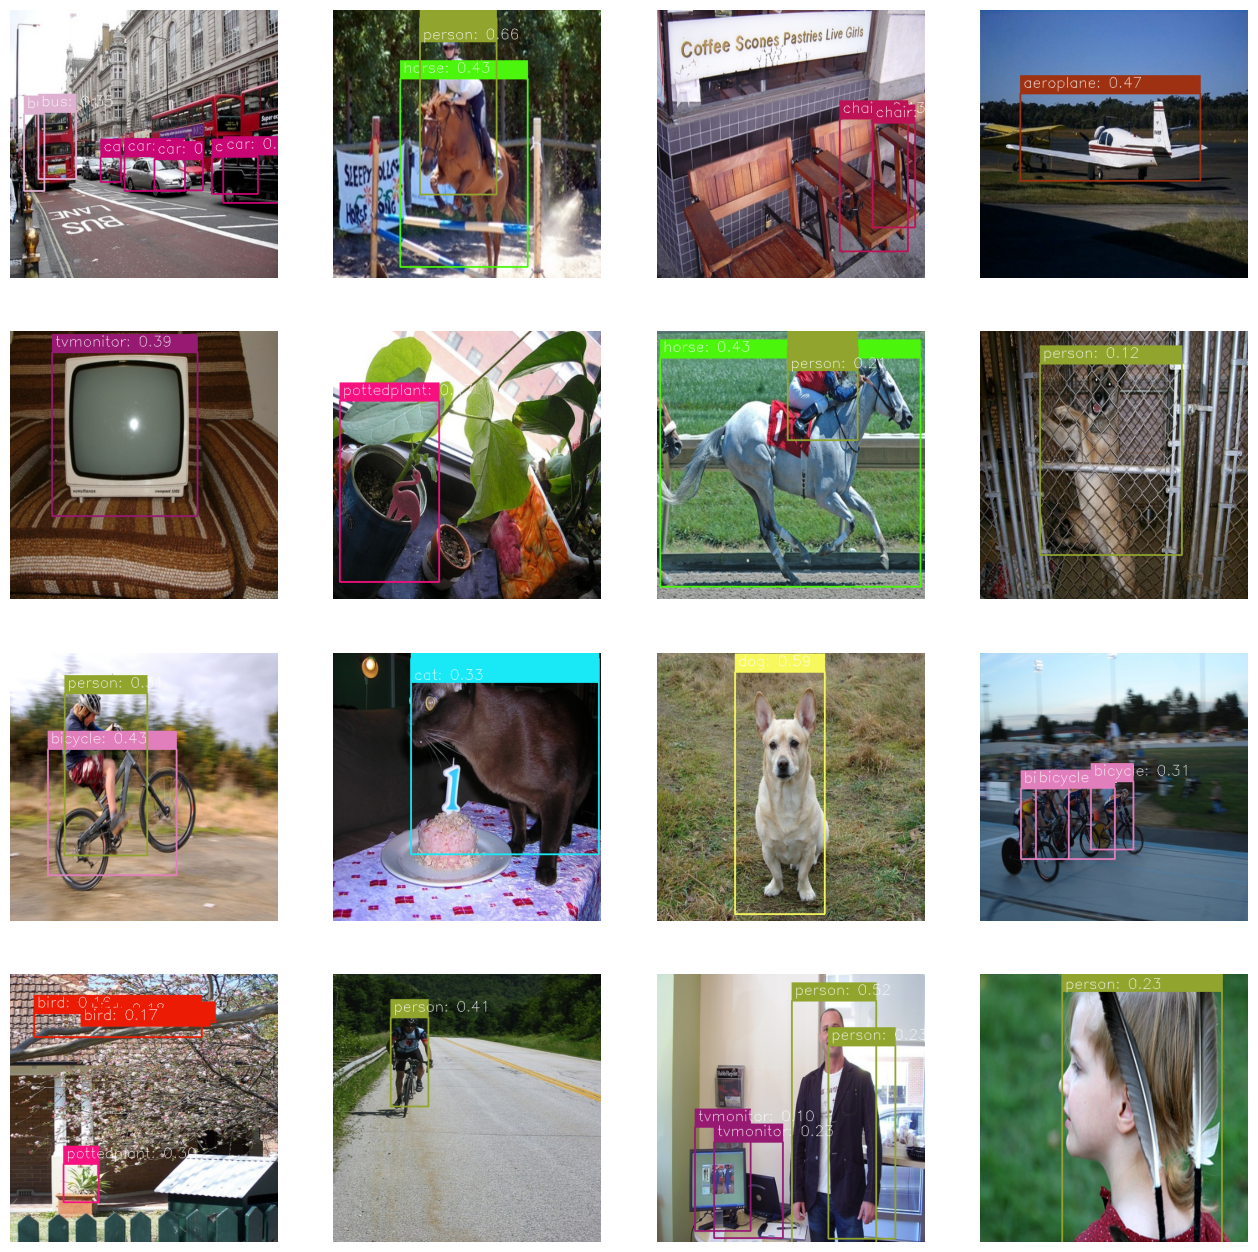

In [46]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [48]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.53
person: 0.47
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 2
person: 0.26
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.41
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

# evaluation

In [23]:
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [24]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [25]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [26]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [27]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [28]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [29]:
evaluator = Evaluator(CONTEXT)

In [30]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)


100%|██████████| 155/155 [01:23<00:00,  1.86it/s]


       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5   0.54225  0.609428  0.523551  0.511138  0.415109  0.480812  0.507622   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.516548  0.500794  0.497532  ...  0.571436  0.578813   0.58168   

          person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.564745    0.503385  0.503078  0.502996  0.562099  0.504121  0.524072  

[1 rows x 21 columns]


In [31]:
result_table.T

AP@0.5
aeroplane     0.54225
bicycle      0.609428
bird         0.523551
boat         0.511138
bottle       0.415109
bus          0.480812
car          0.507622
cat          0.516548
chair        0.500794
cow          0.497532
diningtable  0.504309
dog          0.571436
horse        0.578813
motorbike     0.58168
person       0.564745
pottedplant  0.503385
sheep        0.503078
sofa         0.502996
train        0.562099
tvmonitor    0.504121
all          0.524072

In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )

bird: 0.37
person: 0.34
person: 0.31
person: 0.53
dog: 0.31
motorbike: 0.72
motorbike: 0.86
dog: 0.69
dog: 0.71
person: 0.31
person: 0.40


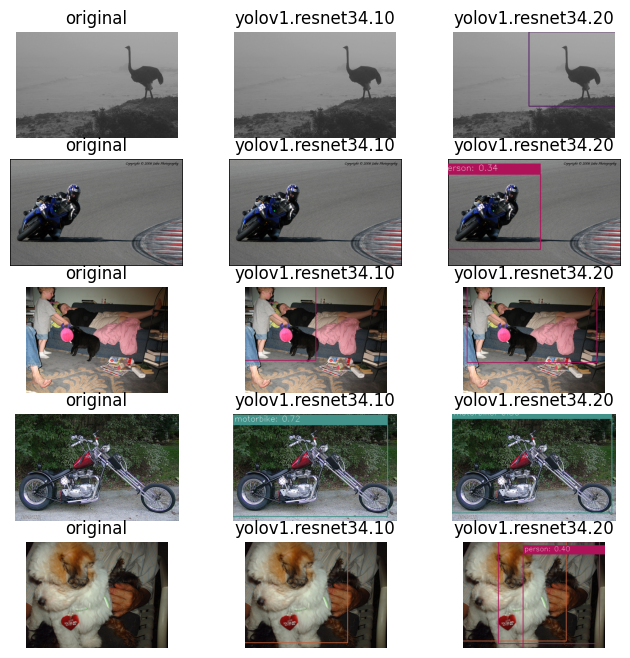

In [ ]:
transform = predictor.prepare_inference()

image_paths = glob('D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/*')
random_selected_image_paths = random.choices(image_paths, k=5)

weight_paths = list(map(str, artifact_path.joinpath(predictor.cfg.MODEL.BACKBONE).glob('*.pth')))

titles = []
predictions = []
for image_path in random_selected_image_paths:
    img = load_image(image_path, is_numpy=True)
    predictions.append(img)
    titles.append('original')
    for weight_path in weight_paths:
        copied_img = img.copy()
        
        predictor.load_weight(weight_path)
        prediction = predictor.detect_single_image(img, transform)
        draw_pred(copied_img, prediction, predictor.class_names, class_color=predictor.palette)
        predictions.append(copied_img)
        titles.append(Path(weight_path).stem)

plot_grids(predictions, titles, 5, 1+len(weight_paths))

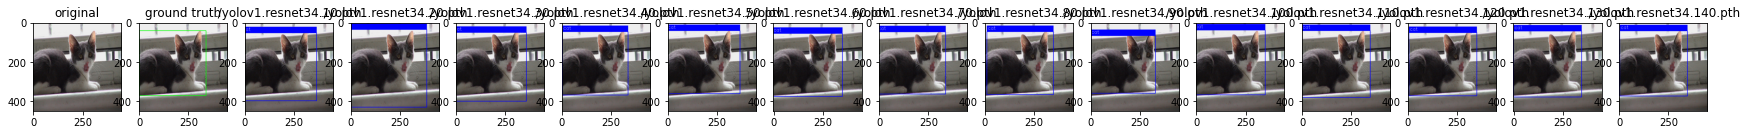

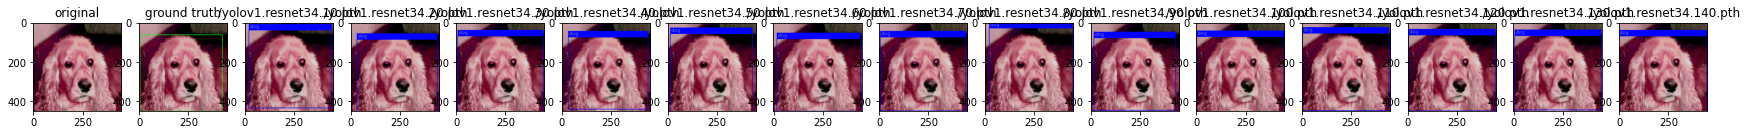

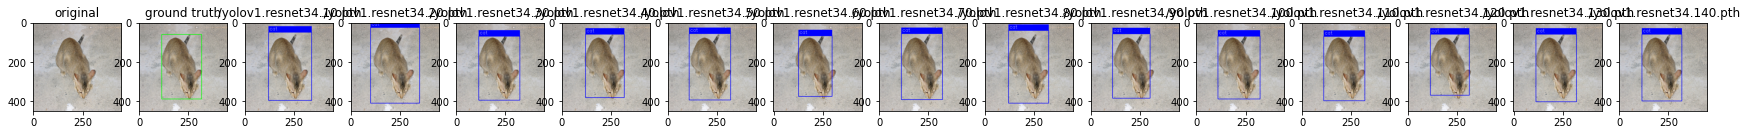

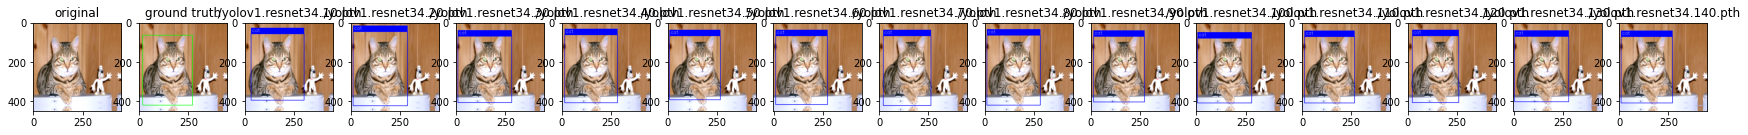

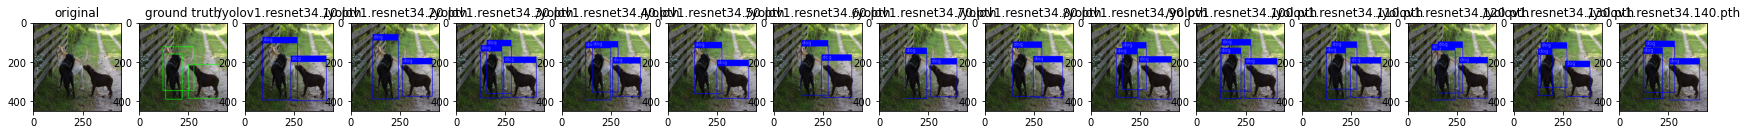

In [ ]:
lots_of_prediction_and_lots_of_model(np.random.randint(low=0,high=len(trainset),size=5),
                                     )

# all epoch evaluation

In [ ]:
result_table = pd.concat([pd.read_csv(eval_file) for eval_file in artifact_path.glob('*eval.csv')], ignore_index=True)

In [ ]:
result_table

Unnamed: 0  aeroplane   bicycle  \
0  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.285928  0.243080   
1  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.334452  0.264394   
2  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.343156  0.264758   

       bird      boat    bottle       bus       car       cat     chair  ...  \
0  0.151106  0.151515  0.090909  0.322694  0.268679  0.421576  0.090909  ...   
1  0.235090  0.160079  0.090909  0.432416  0.271636  0.519197  0.090909  ...   
2  0.237434  0.211670  0.090909  0.425696  0.271030  0.531502  0.090909  ...   

        dog     horse  motorbike    person  pottedplant     sheep      sofa  \
0  0.264929  0.304034   0.250271  0.141176     0.090909  0.090909  0.238564   
1  0.406530  0.402499   0.334981  0.166877     0.090909  0.163636  0.303895   
2  0.423003  0.411214   0.302629  0.171145     0.090909  0.174825  0.285663   

      train  tvmonitor       all  
0  0.327961   0.090909  0.214908  
1  0.414163   0.132353  0.264781  
2  0.403578   0.131752  0.273925  

[3 rows x 22 columns]

<AxesSubplot:>

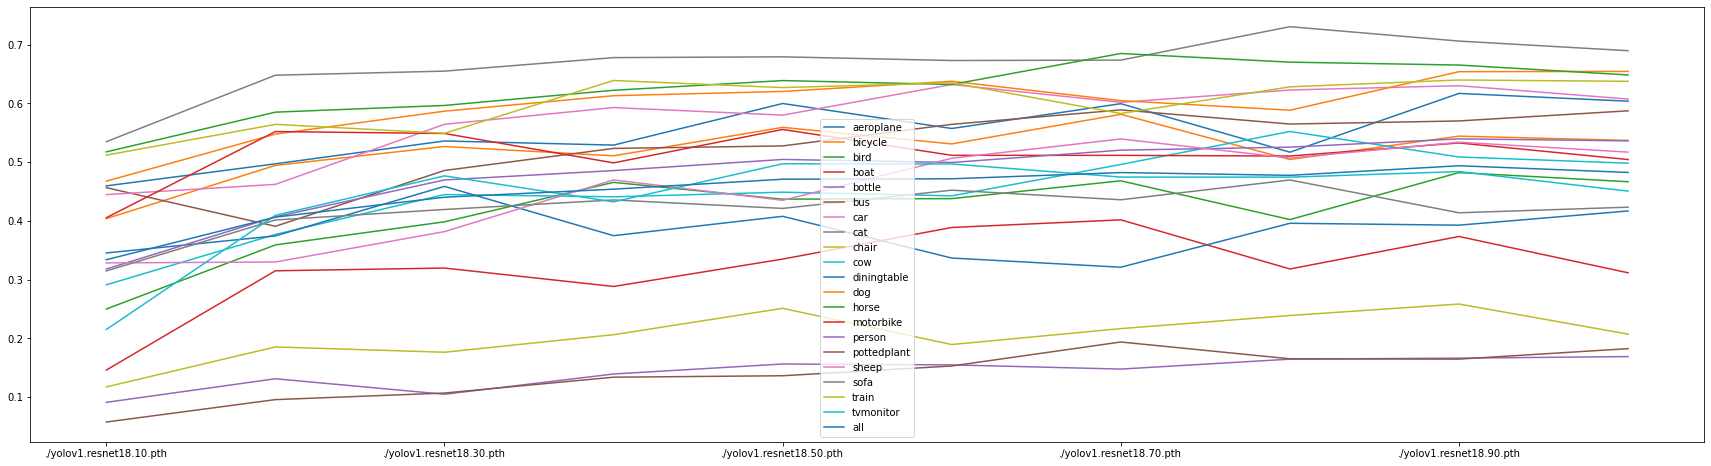

In [ ]:
result_table.plot(figsize=(30,8))

<AxesSubplot:title={'center':'validation mAP on VOC 2007 test set'}>

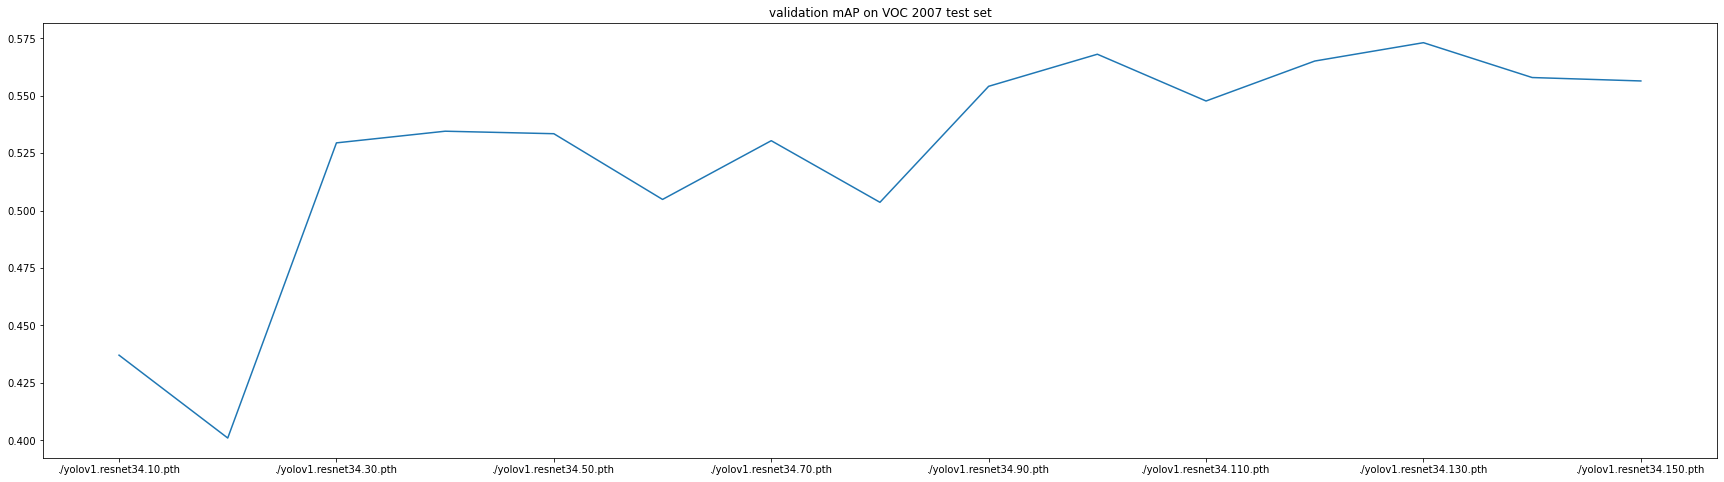

In [ ]:
result_table['all'].plot(figsize=(30,8),title="validation mAP on VOC 2007 test set")

# debug

In [ ]:
AP, _ = evaluator.evaluate_detector(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [01:22<00:00,  1.86it/s]


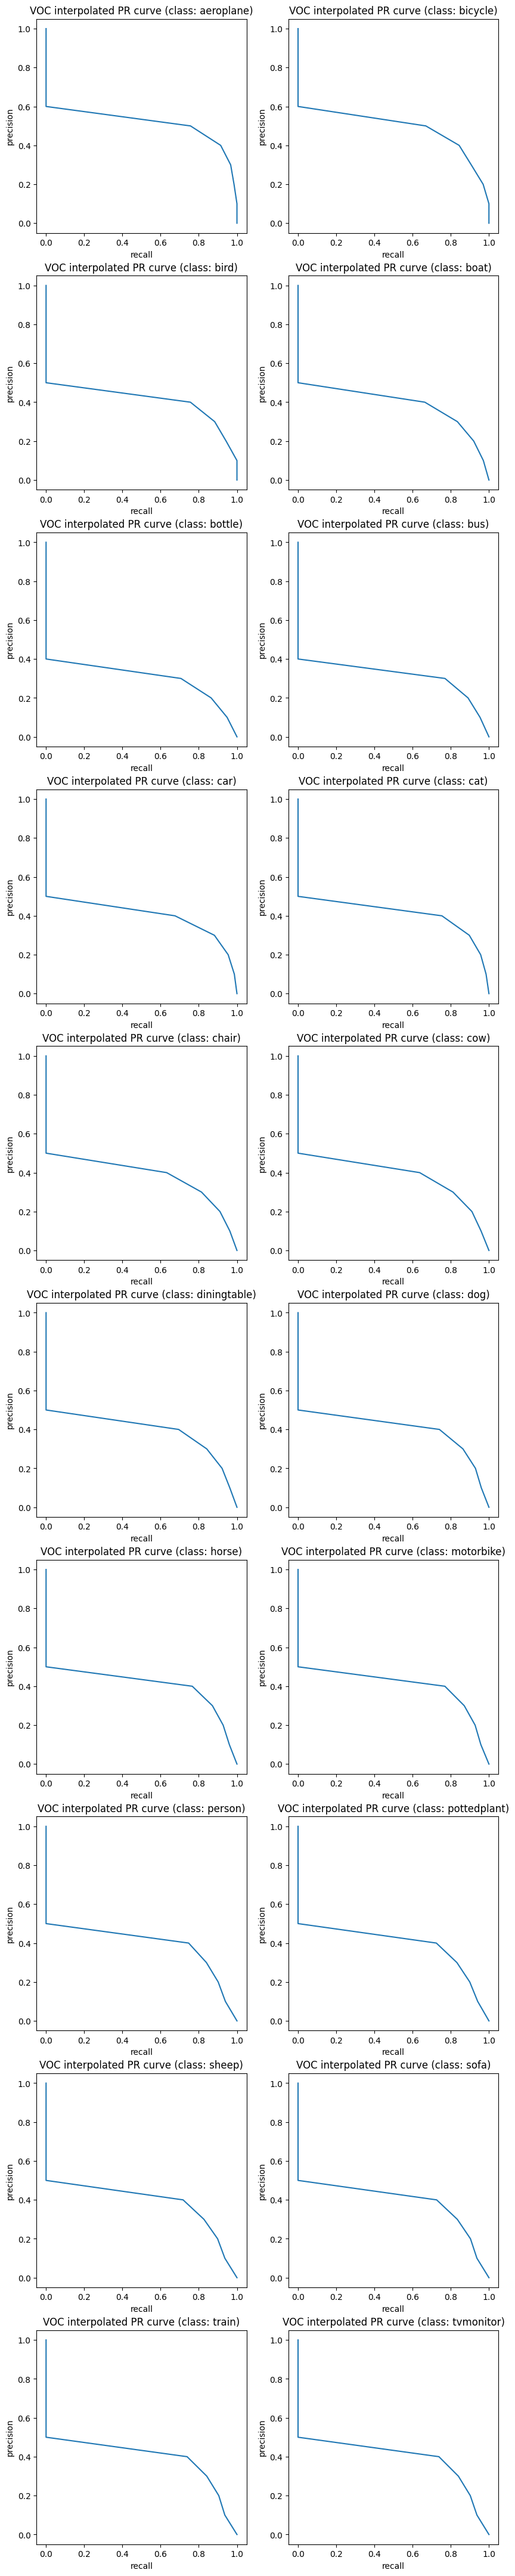

In [ ]:
plt.figure(figsize=(10, 55))
for c_idx, class_name in enumerate(VOC_CLASS_NAMES):
    plt.subplot(len(VOC_CLASS_NAMES) // 2, 2, c_idx+1)
    plt.plot(AP[class_name][0], AP[class_name][1])
    plt.title(f"VOC interpolated PR curve (class: {class_name})")
    plt.xlabel("recall")
    plt.ylabel("precision")

In [ ]:
interest_cls = 'aeroplane'
Iamnotsure = pd.DataFrame({
    'iou': torch.cat([a for a, b, c in debug_map[interest_cls] if a is not None],0).numpy(),
    'prob': torch.cat([b for a, b, c in debug_map[interest_cls] if b is not None],0).numpy(),
    'gt': sum(c for a, b, c in debug_map[interest_cls])
}).sort_values('prob',ascending=False)
Iamnotsure['TP'] = Iamnotsure['iou'].gt(0.5).cumsum()
Iamnotsure['precision'] = Iamnotsure['TP']/np.arange(1,len(Iamnotsure)+1)
Iamnotsure['recall'] = Iamnotsure['TP']/Iamnotsure['gt']
Iamnotsure

iou      prob     gt   TP  precision    recall
71   0.884566  0.890917  265.0    1   1.000000  0.003774
100  0.955297  0.890582  265.0    2   1.000000  0.007547
142  0.851079  0.879476  265.0    3   1.000000  0.011321
134  0.940841  0.871596  265.0    4   1.000000  0.015094
200  0.811990  0.857263  265.0    5   1.000000  0.018868
..        ...       ...    ...  ...        ...       ...
101  0.518033  0.335952  265.0  190   0.867580  0.716981
58   0.000000  0.321791  265.0  190   0.863636  0.716981
164  0.577316  0.320824  265.0  191   0.864253  0.720755
28   0.000000  0.319813  265.0  191   0.860360  0.720755
13   0.655200  0.318804  265.0  192   0.860987  0.724528

[223 rows x 6 columns]

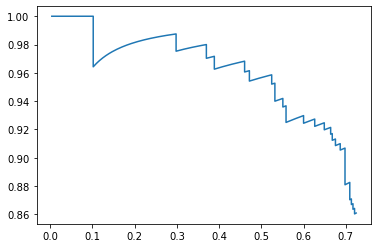

In [ ]:
# plt.ylim(0,1.3)
plt.plot(Iamnotsure['recall'], Iamnotsure['precision'])

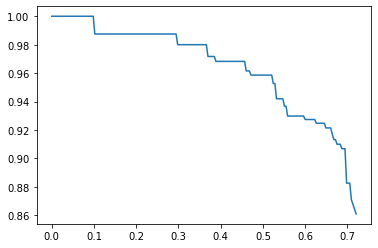

In [ ]:
a,b = all_pr_curve(eval_table[interest_cls]['precision'],eval_table[interest_cls]['recall'])
plt.plot(b, a)

In [ ]:
r18 = pd.read_csv('Final.1e-4/eval.csv',index_col=0)
r34 = pd.read_csv('Final.1e-4.34/eval.csv',index_col=0)

In [ ]:
pd.concat([r18,r34]).loc[['./yolov1.resnet18.150.pth','./yolov1.resnet34.130.pth']].transpose()

./yolov1.resnet18.150.pth  ./yolov1.resnet34.130.pth
aeroplane                     0.659695                   0.699073
bicycle                       0.601857                   0.635265
bird                          0.528688                   0.610817
boat                          0.457822                   0.517191
bottle                        0.199932                   0.248924
bus                           0.630690                   0.716136
car                           0.658628                   0.670062
cat                           0.751293                   0.761671
chair                         0.216588                   0.309187
cow                           0.550103                   0.604650
diningtable                   0.491263                   0.451624
dog                           0.642533                   0.665584
horse                         0.673473                   0.693687
motorbike                     0.577631                   0.619246
person                        0.557463                   0.591511
pottedplant                   0.188593                   0.247500
sheep                         0.479674                   0.601104
sofa                          0.458513                   0.494099
train                         0.693138                   0.739554
tvmonitor                     0.460606                   0.585502
all                           0.523909                   0.573119

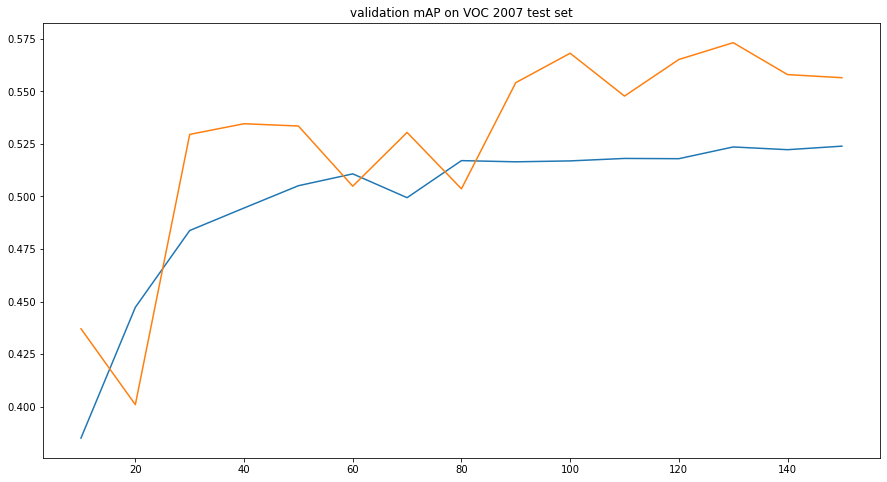

In [ ]:
plt.figure(figsize=(15,8))
plt.title("validation mAP on VOC 2007 test set")
plt.plot(range(10,160,10), r18['all'])
plt.plot(range(10,160,10), r34['all'])